### Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMA
import itertools
import random

### Thoughts on Strategy Employed
<ol>
    <li>The problem requires prediction for a number of days for every store-item pair in the test dataset. Any model developed will be evaluated on the quality of its predictions. Symmetric Mean Absolute Percentage Error (SMAPE) is the metric to use for the evaluation.
    <li>There are, in effect, 500 different timeseries in the train (and test) dataset - one for each store-item pair and predictions need to be made for each of these timeseries. There are 4 possible strategies, <i>in decreasing order of computing power required</i>, to build models and make predictions:
        <ul>
            <li>Build 500 different models, one for each for the store-item pair and then use a model to make predictions for the corresponding series in the test dataset.
            <li>Build 50 different models, one for each item. In this strategy, a model for a item is built by aggregating the daily sales for all stores. Then use every model to make predictions for the corresponding 10 timeseries for the respective item in the test dataset.
            <li>Build 10 different models, one for each store. In this strategy, a model for a store is built by aggregating the daily sales for all items. Then use every model to make predictions for the corresponding 50 timeseries for the respective store in the test dataset. In other words, we build a separate model for each store but apply the same model to all the 50 item series of a store.
            <li>Build a single model. In this strategy, a model is built by aggregating the daily sales for all items across all stores. Then use the model to make predictions for the 500 timeseries in the test dataset.
        </ul>
    <li>We divide the train dataset into to subsets - train and validation. The train subset will be used to build the required models, where as the validation subset will be used to compare the results across the differnt strategies. We divide the train dataset in the ratio 90:10.
    <li>To keep the computing effort manageable, 2 out of the 10 strores and 5 of the 50 items will be randomly chosen, yielding 10 store-item pair combinations. Models under strategies 1 and 2 above will be built only for the relevant store-item pairs or items and predictions under all strategies will be made for only these 10 timeseries. Average SMAPE value across the 10 timeseries will be used to compare the efficacy of the 4 proposed strategies.
</ol>    

### Get Data

In [3]:
train = pd.read_csv('./data/train.csv')

# Typecasting data
train.date = pd.to_datetime(train.date, format = '%Y-%m-%d')     
train.store = train.store.astype('category')
train.item = train.item.astype('category')
# Log Transform Sales
#train['logsales'] = np.log(train.sales)
display(train.head())

random.seed(1970)
stores = random.sample(range(11), 2)    # Choosing 2 of the 10 stores randonly
items = random.sample(range(51), 5)     # Choosing 5 of the 50 items randomly

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


#### Commentary
We build a new timeseries that sums the sales for all stores and all items. 

We fit models to this timeseries and also test the efficacy of those models to predict both for the new timeseries and a store-product pair timeseries.

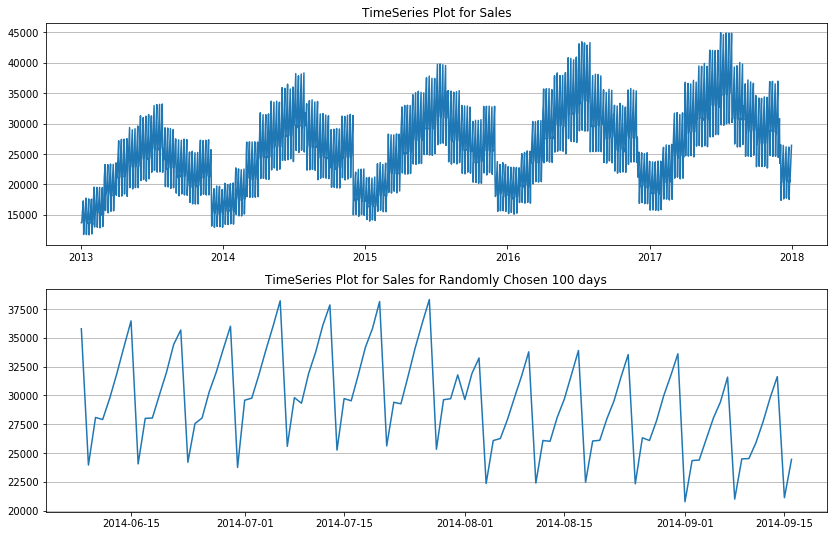

ADF test statistic: -3.0217
Critical Values for ADF test statistic
Conf. Int.    Value
   1%        -3.9638
   5%        -3.4129
  10%        -3.1285

p-value: 1.2612e-01


In [4]:
sales_all = train.groupby('date')['sales'].sum()
sales_all.index = pd.DatetimeIndex(sales_all.index.values, freq = 'D')

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (14, 9))
ax1.plot(sales_all.index, sales_all)
ax1.set_title('TimeSeries Plot for Sales')
ax1.grid(axis = 'y')

ax2.plot(sales_all.index[523:624], sales_all[523:624])
ax2.set_title('TimeSeries Plot for Sales for Randomly Chosen 100 days')
ax2.grid(axis = 'y')
plt.show()

result = adfuller(sales_all, regression = 'ct')
print("ADF test statistic: %0.4f" % result[0])
print("Critical Values for ADF test statistic")
print("Conf. Int.    Value")
for _, (key, value) in enumerate(result[4].items()):
    print("  %3s        %0.4f" % (key, value))
print("\np-value: %0.4e" % result[1])

#### Observations
The first graph shows two trends in the data - 
    a month-on-month trend in a year - sales go up for first half of the year and come down in the second half and this trend repeats year after year, and 
    an upward year-on-year trend.
    
The second graph shows that there is trend within week - for the week starting Monday, daily sales go up getting to their highest value on Sunday.

Moreover, the Augmented Dickey-Fuller (ADF) test confirms that the series is not stationary.
    
To apply ARIMA/SARIMA models we need to make the series stationary. To that end we difference the series and then visually and formulaicly test if the new series is stationary.

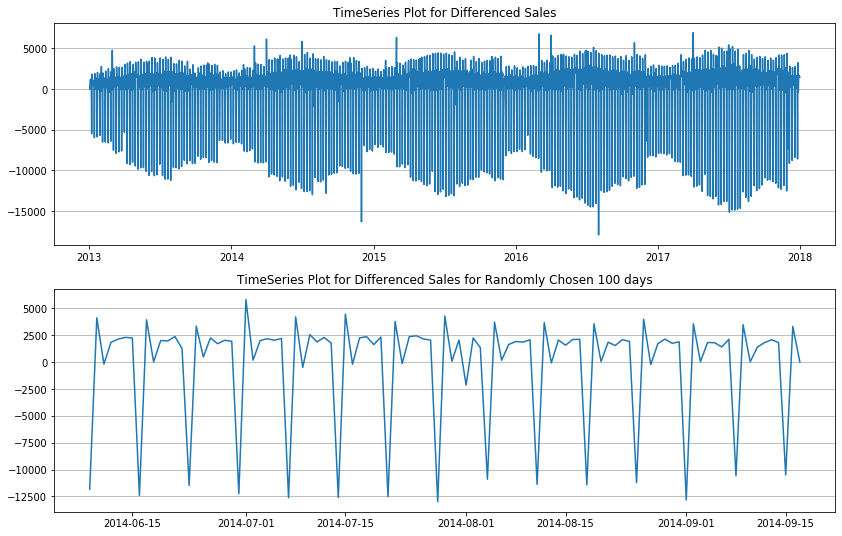

In [35]:
sales_all_1 = sales_all.diff().dropna()

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (14, 9))
ax1.plot(sales_all_1.index, sales_all_1)
ax1.set_title('TimeSeries Plot for Differenced Sales')
ax1.grid(axis = 'y')

ax2.plot(sales_all_1.index[523:624], sales_all_1[523:624])
ax2.set_title('TimeSeries Plot for Differenced Sales for Randomly Chosen 100 days')
ax2.grid(axis = 'y')
plt.show()

In [6]:
result = adfuller(sales_all_1)                # Notice that regression = 'none' as there is no visible trend 
                                              # to the differenced series.
print("ADF test statistic: %0.4f" % result[0])
print("Critical Values for ADF test statistic")
print("Conf. Int.    Value")
for _, (key, value) in enumerate(result[4].items()):
    print("  %3s        %0.4f" % (key, value))
print("\np-value: %0.4e" % result[1])

ADF test statistic: -8.9190
Critical Values for ADF test statistic
Conf. Int.    Value
   1%        -3.4340
   5%        -2.8631
  10%        -2.5676

p-value: 1.0534e-14


#### Observations
We can confirm visually that the differenced series is stationary in that it seems to have a constant mean and constant variance. Moreover, the ADF test confirms this observation.

We use this transformed series to build the ARIMA/SARIMA models.

We first investigate the existence of autocorrelation in the series using the Ljung-Box test and then investigate the ACF and PACF plots for the series.

In [7]:
result = acorr_ljungbox(sales_all_1, lags = 10, return_df = True)
print('The p-value for the Ljung-Box test statistic for the first 10 lags:')
print(result.lb_pvalue.head(10))

The p-value for the Ljung-Box test statistic for the first 10 lags:
1      8.698029e-46
2      1.472491e-44
3      1.847159e-52
4      2.766107e-60
5      2.359325e-59
6     1.929484e-101
7      0.000000e+00
8      0.000000e+00
9      0.000000e+00
10     0.000000e+00
Name: lb_pvalue, dtype: float64


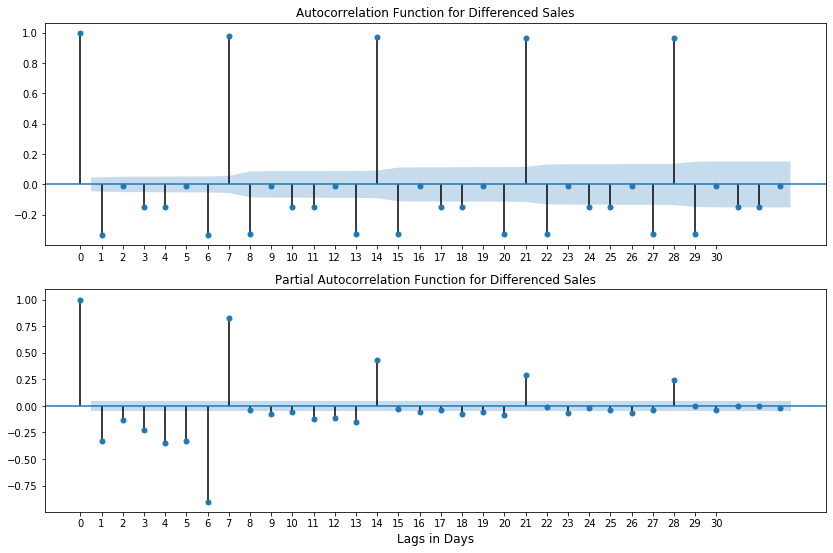

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (14, 9))

tsaplots.plot_acf(sales_all_1, ax = ax1, alpha = 0.05,
                  title = 'Autocorrelation Function for Differenced Sales')
tsaplots.plot_pacf(sales_all_1, ax = ax2, alpha = 0.05,
                   title = 'Partial Autocorrelation Function for Differenced Sales')

ax1.set_xticks(np.arange(0, 31, 1))
ax2.set_xticks(np.arange(0, 31, 1))
ax2.set_xlabel('Lags in Days', fontsize = '12')

plt.show()

#### Observations

Since the series was differenced before plotting the ACF and PACF; d = 1 (and D = 0).

Regular peaks in both ACF and PACF at lags 7, 14, 21, 28; s = 7

Near term peaks in ACF at lags 1, 3, 4 and 6, p = 1, (1, 3), (1, 3 ,4), (1, 3, 4, 6) and P = 0, 1

Near term peaks in PACF at lags 1 thru 6, q = 1, 2, 3, 4, 5, 6 and Q = 0, 1

Grid Search optimal values for the SARIMA parameters using AIC as the criterion for choice. We split the sales_all_1 dataset into train and val subsets. The train subset consists of the first 90% elements of the sales_all_1 dataset.

To dampen the variations in the values of sales_all_1, we log transform it and then perform the grid search.


In [36]:
sales_all_1_log = np.log(sales_all_1)

n_train = np.int(0.9*len(sales_all_1))
history = sales_all_1[:n_train]
future = sales_all_1[n_train:]
history_log = sales_all_1_log[:n_train]
future_log = sales_all_1_log[n_train:]

/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [28]:
ma_order = [1, (1, 0, 1), (1, 0, 1, 1), (1, 0, 1, 1, 0, 1)]
ar_order = np.arange(1, 7)
ma_sorder = np.arange(0, 2)
ar_sorder = np.arange(0, 2)
diff = np.arange(1, 2)
diff_s = np.arange(0, 1)
span_s = np.arange(7, 8)
trend = ['n']

for p in ma_order:
    for q in ar_order:
        for P in ma_sorder:
            for Q in ar_sorder:
                for d in diff:
                    for D in diff_s:
                        for s in span_s:
                            for t in trend:
                                try:
                                    model = SARIMAX(history_log, order = (p, d, q), 
                                                    seasonal_order = (P, D, Q, s),
                                                    trend = t, enforce_stationarity = False, 
                                                    enforce_invertability = False).fit(method = 'powell', 
                                                                                       disp = False)
                                    print('SARIMA{}{} trend {} - AIC:{}'.format((p,d,q), (P,D,Q,s), t, 
                                                                               model.aic))
                                except:
                                    continue

SARIMA(1, 1, 1)(0, 0, 0, 7) trend n - AIC:3237.344790718572
SARIMA(1, 1, 1)(0, 0, 1, 7) trend n - AIC:2572.565745582473
SARIMA(1, 1, 2)(0, 0, 0, 7) trend n - AIC:3236.649128395672
SARIMA(1, 1, 2)(0, 0, 1, 7) trend n - AIC:2572.342724004723
SARIMA(1, 1, 3)(0, 0, 0, 7) trend n - AIC:3159.3246952216696
SARIMA(1, 1, 3)(0, 0, 1, 7) trend n - AIC:2550.4255474241877
SARIMA(1, 1, 4)(0, 0, 0, 7) trend n - AIC:3161.36091306281
SARIMA(1, 1, 4)(0, 0, 1, 7) trend n - AIC:2552.1041835266915
SARIMA(1, 1, 5)(0, 0, 0, 7) trend n - AIC:3125.1563279360767
SARIMA(1, 1, 5)(0, 0, 1, 7) trend n - AIC:2525.2227214324403
SARIMA(1, 1, 6)(0, 0, 0, 7) trend n - AIC:3014.079378264153
SARIMA(1, 1, 6)(0, 0, 1, 7) trend n - AIC:2521.1658192174727
SARIMA((1, 0, 1), 1, 1)(0, 0, 0, 7) trend n - AIC:3236.879065279564
SARIMA((1, 0, 1), 1, 1)(0, 0, 1, 7) trend n - AIC:2571.9594062623714
SARIMA((1, 0, 1), 1, 2)(0, 0, 0, 7) trend n - AIC:3111.4535062191944
SARIMA((1, 0, 1), 1, 2)(0, 0, 1, 7) trend n - AIC:2512.5392948582557


/home/sanjeev/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA((1, 0, 1, 1), 1, 1)(0, 0, 0, 7) trend n - AIC:3234.377831874761
SARIMA((1, 0, 1, 1), 1, 1)(0, 0, 1, 7) trend n - AIC:2564.56685916031
SARIMA((1, 0, 1, 1), 1, 2)(0, 0, 0, 7) trend n - AIC:2966.6635126943024
SARIMA((1, 0, 1, 1), 1, 2)(0, 0, 1, 7) trend n - AIC:2426.356553013985
SARIMA((1, 0, 1, 1), 1, 3)(0, 0, 0, 7) trend n - AIC:2893.2164199981
SARIMA((1, 0, 1, 1), 1, 3)(0, 0, 1, 7) trend n - AIC:2418.5965422892655
SARIMA((1, 0, 1, 1), 1, 4)(0, 0, 0, 7) trend n - AIC:2400.338415079663
SARIMA((1, 0, 1, 1), 1, 4)(0, 0, 1, 7) trend n - AIC:1954.0731069542576
SARIMA((1, 0, 1, 1), 1, 5)(0, 0, 0, 7) trend n - AIC:2383.3057763804527
SARIMA((1, 0, 1, 1), 1, 5)(0, 0, 1, 7) trend n - AIC:1944.497055375464
SARIMA((1, 0, 1, 1), 1, 6)(0, 0, 0, 7) trend n - AIC:2314.525038581626
SARIMA((1, 0, 1, 1), 1, 6)(0, 0, 1, 7) trend n - AIC:1928.477035575428
SARIMA((1, 0, 1, 1, 0, 1), 1, 1)(0, 0, 0, 7) trend n - AIC:3006.1239911465946
SARIMA((1, 0, 1, 1, 0, 1), 1, 1)(0, 0, 1, 7) trend n - AIC:2447.34465

Best Model SARIMA((1, 0, 1), 1, 5)(0, 0, 1, 7) trend n - AIC:1926.2198357163888


Build a model using these parameters and test subset and predict for validation subset.

To asess the quality of the model, investigate the residues.

In [37]:
model = SARIMAX(history_log, order = ((1, 0, 1), 1, 5), seasonal_order = (0, 0, 1, 7),
                                                    trend = t, enforce_stationarity = False, 
                                                    enforce_invertability = False)
m_fit = model.fit(method = 'powell', disp = False)
m_residues = m_fit.resid

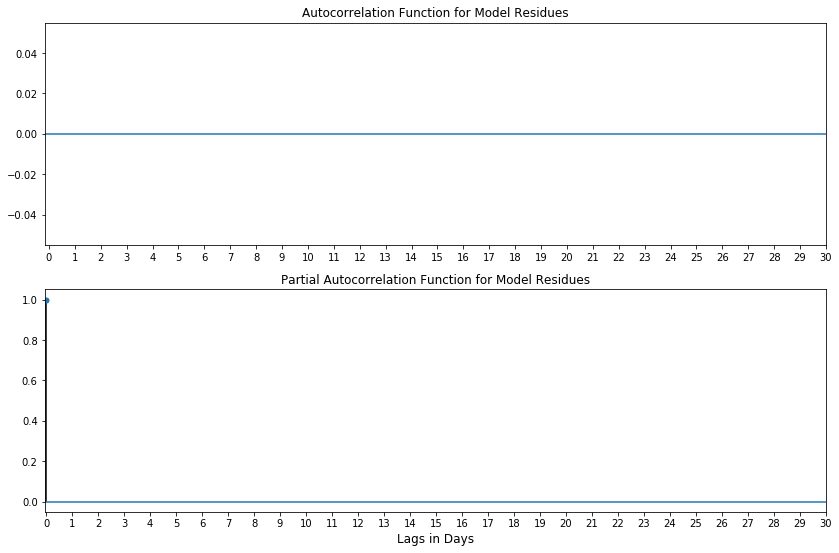

In [38]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (14, 9))

tsaplots.plot_acf(m_residues, ax = ax1, alpha = 0.05,
                  title = 'Autocorrelation Function for Model Residues')
tsaplots.plot_pacf(m_residues, ax = ax2, alpha = 0.05,
                   title = 'Partial Autocorrelation Function for Model Residues')

ax1.set_xticks(np.arange(0, 31, 1))
ax2.set_xticks(np.arange(0, 31, 1))
ax2.set_xlabel('Lags in Days', fontsize = '12')

plt.show()

#### Observations

The residues series for the fitted model show no auto correlation or partial auto correlation pointing to a model that is of good quality.

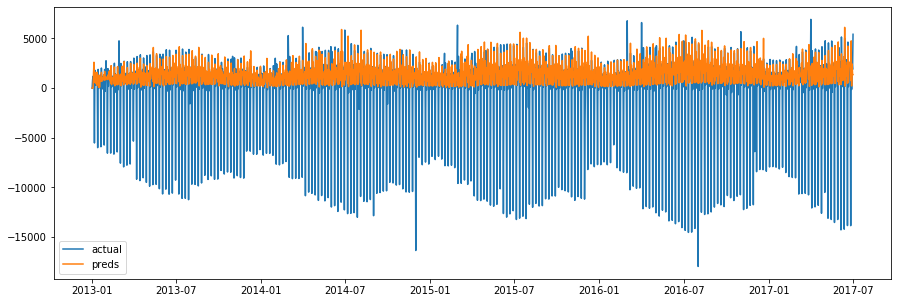

In [39]:
preds_log = m_fit.predict(history_log.index[0], history_log.index[-1])
preds = np.exp(preds_log)

plt.figure(figsize = (15, 5))
plt.plot(history.index, history, label = 'actual')
plt.plot(history.index, preds, label = 'preds')
plt.legend()
plt.show()

In [40]:
np.mean(abs(history-preds)/(abs(history) + abs(preds)))*100

35.32226991292553

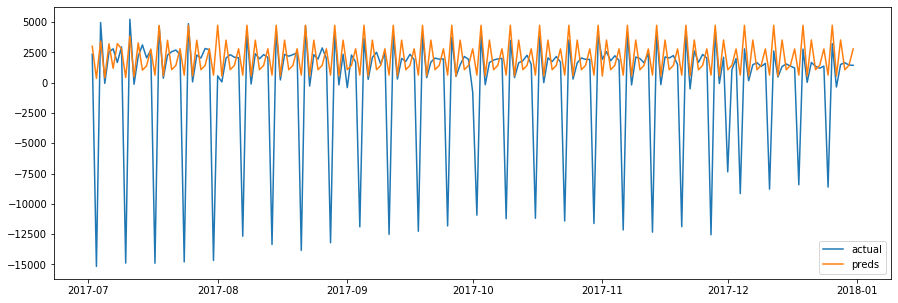

In [41]:
preds_log = m_fit.predict(future_log.index[0], future_log.index[-1])
preds = np.exp(preds_log)

plt.figure(figsize = (15, 5))
plt.plot(future.index, future, label = 'actual')
plt.plot(future.index, preds, label = 'preds')
plt.legend()
plt.show()

In [42]:
np.mean(abs(future-preds)/(abs(future) + abs(preds)))*100

40.19480768286083

               ---------------*****************---------------------***********************---------------